# Conditional synthetic gradients demo

### A project by Sam Greydanus. <a href="https://opensource.org/licenses/MIT">MIT license</a>

This is just like my synthetic gradients code, but the model which predicts the synthetic gradients also takes the training label as in input. Runtime is slower and accuracy is worse for this model, which surprised me. It's probably due to one of the following
* a simple bug in the code
* poor initialization
* this toy model is too small for the concatenated training label to really matter

## Load dependencies and data

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data # just use tensorflow's mnist api
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Hyperparameters

In [2]:
global_step = 0
batch_size = 5
lr = 2e-2       # model learning rate
slr = 1e-4      # synthetic learning rate
h1_size = 100   # first hidden layer
h2_size = 10    # second hidden layer
D = 28*28       # dimensionality
synth_step = 10 # ratio of model updates to synthetic gradient updates

## Model Initialization

In [3]:
model = {}
# first layer
model['W1'] = np.random.randn(D,h1_size) / np.sqrt(h1_size) # Xavier initialization
model['b1'] = np.random.randn(1,h1_size) / np.sqrt(h1_size) # see http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf
#second layer
model['W2'] = np.random.randn(h1_size,h2_size) / np.sqrt(h2_size)
model['b2'] = np.random.randn(1,h2_size) / np.sqrt(h2_size)

# model for predicting synthetic gradients
smodel = { k : np.random.randn(v.shape[1] + h2_size, np.prod(v.shape)) * 0.1 / np.sqrt(np.prod(v.shape)) \
          for k,v in model.iteritems() }

In [4]:
# model functions
def xW_plus_b(x, W, b):
    return np.dot(x,W) + b # in some cases you can even drop the bias b
def softmax(x):
    maxes = np.amax(x, axis=1, keepdims=True)
    e = np.exp(x - maxes) # improves numerics
    dist = e / np.sum(e, axis=1, keepdims=True)
    return dist
def relu(x):
    x[x<0] = 0
    return x

# derivatives of model functions
# see https://nbviewer.jupyter.org/github/greydanus/np_nets/blob/master/mnist_nn.ipynb for derivations
def dsoftmax(h, y, batch_size):
    h[range(batch_size),y] -= 1
    return h/y.shape[0] # divide by batch size
def drelu(dz, h):
    dz[h <= 0] = 0 # backprop relu
    return dz
def dxW_plus_b(dh, model):
    return np.dot(dh, model['W2'].T)

In [5]:
def forward(X, model):
    # evaluate class scores, [N x K]
    hs = [] # we'll need the h's for computing gradients
    h1 = relu(np.dot(X, model['W1']) + model['b1']) ; hs.append(h1)
    h2 = relu(np.dot(h1, model['W2']) + model['b2']); hs.append(h2)
    probs = softmax(h2)
    return probs, hs

def backward(y, probs, hs, model):
    grads = { k : np.zeros_like(v) for k,v in model.iteritems() }
    dh2 = dsoftmax(probs, y, batch_size)
    # second hidden layer
    grads['W2'] = np.dot(hs[0].T, dh2)
    grads['b2'] = np.sum(dh2, axis=0, keepdims=True)
    # first hidden layer
    dh1 = dxW_plus_b(dh2, model)
    dh1 = drelu(dh1, hs[0]) # backprop through relu
    grads['W1'] = np.dot(X.T, dh1)
    grads['b1'] = np.sum(dh1, axis=0, keepdims=True)
    return grads

# forward propagate synthetic grad model
def sforward(hs, smodel, model):
    synthetic_grads = { k : np.zeros_like(v) for k,v in smodel.iteritems() }
    synthetic_grads['W1'] = np.dot(hs[0], smodel['W1'])
    synthetic_grads['b1'] = np.dot(hs[0], smodel['b1'])
    synthetic_grads['W2'] = np.dot(hs[1], smodel['W2'])
    synthetic_grads['b2'] = np.dot(hs[1], smodel['b2'])
    return synthetic_grads

# backward propagate synthetic grad model
def sbackward(hs, ds, smodel):
    sgrads = { k : np.zeros_like(v) for k,v in smodel.iteritems() }
    sgrads['W2'] = np.dot(hs[1].T, ds['W2'])
    sgrads['b2'] = np.dot(hs[1].T, ds['b2'])
    sgrads['W1'] = np.dot(hs[0].T, ds['W1'])
    sgrads['b1'] = np.dot(hs[0].T, ds['b1'])
    return sgrads

## Evaluation metric

In [6]:
# evaluate training set accuracy
def eval_model(model):
    X = mnist.test.images
    y = mnist.test.labels
    _, y = np.where(y==1)
    hidden_layer = np.maximum(0, np.dot(X, model['W1']) + model['b1'])
    scores = np.dot(hidden_layer, model['W2']) + model['b2']
    predicted_class = np.argmax(scores, axis=1)
    return(np.mean(predicted_class == y))

## Training loop

In [7]:
loss_history = []
smoothing_factor = 0.95
for i in xrange(global_step, 7500):
    X, y = mnist.train.next_batch(batch_size)
    _, yix = np.where(y==1) # indices of y values
    
    probs, hs = forward(X, model)
    cond_hs = [np.concatenate((h,y),axis=1) for h in hs]
    synthetic_grads = sforward(cond_hs, smodel, model) # compute synthetic gradients
    
    # synthetic gradient model updates
    if i % synth_step == 0:
        # compute the loss
        y_logprobs = -np.log(probs[range(batch_size),yix])
        loss = np.sum(y_logprobs)/batch_size
        
        if i is 0 : smooth_loss = loss
        grads = backward(yix, probs, hs, model) # data gradients

        # compute the synthetic gradient loss
        ds = {k : - v.ravel() + synthetic_grads[k] for (k, v) in grads.iteritems()}
        squared_errors = [np.sum(slr*v*v) for v in ds.itervalues()]
        sloss = np.sum(squared_errors)/batch_size
        sgrads = sbackward(cond_hs, ds, smodel)
        smodel = {k : smodel[k] - slr*sgrads[k] for (k,v) in sgrads.iteritems()} # update smodel parameters
        
        # boring book-keeping
        smooth_loss = smoothing_factor*smooth_loss + (1-smoothing_factor)*loss
        loss_history.append((i,smooth_loss))
    if (i+1) % 1000 == 0:
        print "iteration {}: test accuracy {:3f}".format(i, eval_model(model))
    if (i) % 250 == 0:
        print "\titeration {}: smooth_loss {:3f}, synth_loss {:3f}".format(i, smooth_loss, sloss)
    
    # estimate gradients using synthetic gradient model
    est_grad = {k : np.reshape(np.sum(v, axis=0), grads[k].shape)/batch_size for k,v in synthetic_grads.iteritems()}
    model = {k : model[k] - lr*v for (k,v) in est_grad.iteritems()} # update model using estimated gradient
    global_step += 1

	iteration 0: smooth_loss 2.705045, synth_loss 0.009632
	iteration 250: smooth_loss 2.314777, synth_loss 0.008629
	iteration 500: smooth_loss 1.602781, synth_loss 0.001813
	iteration 750: smooth_loss 1.326191, synth_loss 0.002725
iteration 999: test accuracy 0.728900
	iteration 1000: smooth_loss 0.860206, synth_loss 0.000922
	iteration 1250: smooth_loss 1.322095, synth_loss 0.001997
	iteration 1500: smooth_loss 1.240466, synth_loss 0.005177
	iteration 1750: smooth_loss 1.790487, synth_loss 0.006122
iteration 1999: test accuracy 0.757400
	iteration 2000: smooth_loss 1.391199, synth_loss 0.000152
	iteration 2250: smooth_loss 1.094848, synth_loss 0.005085
	iteration 2500: smooth_loss 0.880262, synth_loss 0.001397
	iteration 2750: smooth_loss 0.969627, synth_loss 0.000243
iteration 2999: test accuracy 0.819100
	iteration 3000: smooth_loss 0.665827, synth_loss 0.002108
	iteration 3250: smooth_loss 0.897908, synth_loss 0.006261
	iteration 3500: smooth_loss 0.985653, synth_loss 0.003354
	iter

54.862700% same sign out of 1748 nonzero gradients
Plotting grads vs est_grads for W2 parameters


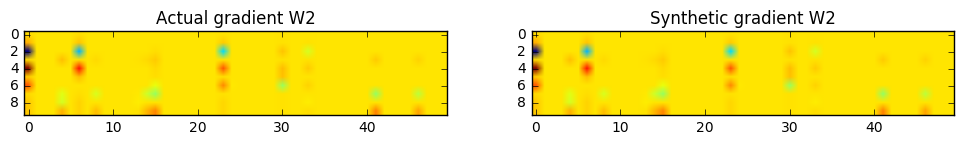

In [9]:
# first, flatten all gradients and estimated gradients
g, s = np.zeros((0)), np.zeros((0))
for (k,v) in grads.iteritems():
    g = np.concatenate((g,copy.deepcopy(v.ravel())))
    s = np.concatenate((s,copy.deepcopy(est_grad[k].ravel())))

# now keep only those which are fairly large and see if their signs agree
eps = 1e-3
s[np.abs(s)<eps] = 0 ; g[np.abs(g)<eps] = 0 # ignore deviations of epsilon around 0
num_zeros = sum(s.ravel() * g.ravel() == 0)
num_matching_signs = sum(s.ravel() * g.ravel() > 0)

percentage = float (num_matching_signs) / (len(g) - num_zeros) * 100
print "{:2f}% same sign out of {} nonzero gradients".format(percentage, len(g) - num_zeros)

# plot first 2500 gradients
print "Plotting grads vs est_grads for W2 parameters"
sample = np.random.randint(len(g), size=500)
plt.figure(figsize=(12,16))
plt.subplot(121) ; plt.title("Actual gradient W2")
plt.imshow(grads['W2'].T[:,:50], cmap=cm.jet)
plt.subplot(122) ; plt.title("Synthetic gradient W2")
plt.imshow(grads['W2'].T[:,:50], cmap=cm.jet)
plt.show()

## Visualize training loss

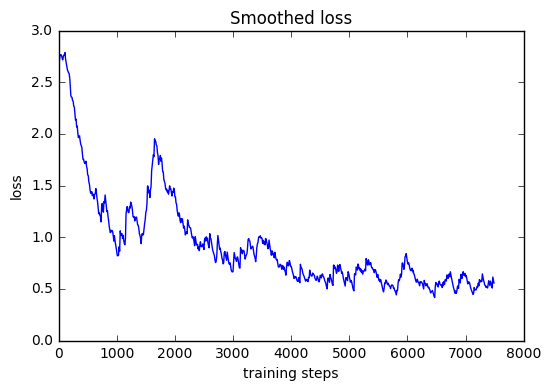

In [10]:
plt.title("Smoothed loss")
plt.xlabel("training steps")
plt.ylabel("loss")

train_steps, smoothed_losses = zip(*loss_history)
plt.plot(train_steps, smoothed_losses)
plt.show()

## Sample model

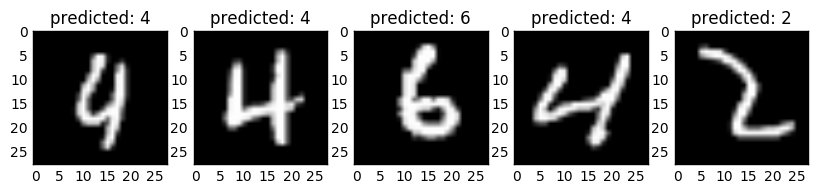

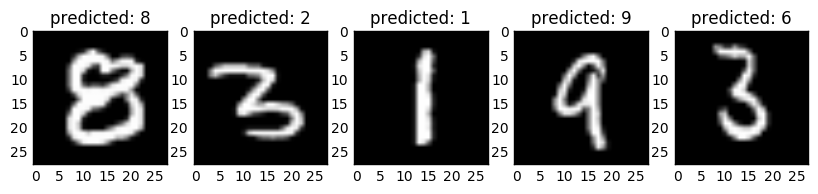

In [11]:
X = mnist.test.images
y = mnist.test.labels
hidden_layer = np.maximum(0, np.dot(X, model['W1']) + model['b1'])
scores = np.dot(hidden_layer, model['W2']) + model['b2']
predicted_class = np.argmax(scores, axis=1)

r = np.random.randint(1000)
for i in range(0 + r,10 + r,5):
    img1 = np.reshape(X[i+0,:], (28,28))
    img2 = np.reshape(X[i+1,:], (28,28))
    img3 = np.reshape(X[i+2,:], (28,28))
    img4 = np.reshape(X[i+3,:], (28,28))
    img5 = np.reshape(X[i+4,:], (28,28))
    plt.figure(i, figsize=(10,4))
    plt.subplot(151) ; plt.title("predicted: " + str(predicted_class[i]))
    plt.imshow(img1, cmap=cm.gray)
    plt.subplot(152) ; plt.title("predicted: " + str(predicted_class[i+1]))
    plt.imshow(img2, cmap=cm.gray)
    plt.subplot(153) ; plt.title("predicted: " + str(predicted_class[i+2]))
    plt.imshow(img3, cmap=cm.gray)
    plt.subplot(154) ; plt.title("predicted: " + str(predicted_class[i+3]))
    plt.imshow(img4, cmap=cm.gray)
    plt.subplot(155) ; plt.title("predicted: " + str(predicted_class[i+4]))
    plt.imshow(img5, cmap=cm.gray)